# Load Model



In [1]:
import config

import cv2
import einops
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler


apply_canny = CannyDetector()

# config_path = './configs/multi-cldm_v15.yaml'
config_path = '/home/lolicon/data/dataset/lycoris/model.yaml'

model = create_model(config_path).cpu()


torch_device = 'cuda'

# send to device
model = model.to(torch_device)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.
MultiControlLDM: Running in eps-prediction mode


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.mlp.fc1.bias', 'vision_model.encoder.layers

Loaded model config from [/home/lolicon/data/dataset/lycoris/model.yaml]


In [1]:
from utils.model_loader import load_state_dict

what = load_state_dict('/home/lolicon/data/dataset/lycoris/lora_ckpt/epoch=99.ckpt')
print(what.keys())

Loaded state_dict from [/home/lolicon/data/dataset/lycoris/lora_ckpt/epoch=99.ckpt]
odict_keys(['lora_unet_input_blocks_1_1_proj_in.alpha', 'lora_unet_input_blocks_1_1_proj_in.lora_down.weight', 'lora_unet_input_blocks_1_1_proj_in.lora_up.weight', 'lora_unet_input_blocks_1_1_proj_in.org_module.weight', 'lora_unet_input_blocks_1_1_proj_in.org_module.bias', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_q.alpha', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_q.lora_down.weight', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_q.lora_up.weight', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_q.org_module.weight', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_k.alpha', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_k.lora_down.weight', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_k.lora_up.weight', 'lora_unet_input_blocks_1_1_transformer_blocks_0_attn1_to_k.org_module.weight', 'lora_unet_input_blocks_1_1_transf

# Load weight

In [3]:

from utils.model_loader import load_state_dict

# # weight for unet, encoder, decoder, text embedding 
# main_ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors'

# # weight for control net 
# ctrl_pose_path = '../stable-diffusion-webui/models/ControlNet/control_sd15_canny.pth'

# sd_ckpt = load_state_dict(main_ckpt_path)
# sd_ctrl = load_state_dict(ctrl_pose_path)
# model.load_multi_state_dict(sd_ckpt, canny_model=sd_ctrl)

sd_ckpt = load_state_dict('/home/lolicon/data/dataset/lycoris/ckpt/epoch=99.ckpt')
model.load_state_dict(sd_ckpt)


Loaded state_dict from [/home/lolicon/data/dataset/lycoris/ckpt/epoch=99.ckpt]


<All keys matched successfully>

# Create Sampler

In [4]:
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from modules.sampler import VanillaStableDiffusionSampler

webui_sampler = VanillaStableDiffusionSampler(DDIMSampler, model)
orig_sampler = DDIMSampler(model)


# Text to Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
cuda
the postive text embedding: tensor([[[-0.3775,  0.0151, -0.0611,  ..., -0.5000, -0.2917,  0.0669],
         [-2.3404, -0.1266,  2.0319,  ..., -0.1971,  0.6385,  2.2474],
         [-1.6982,  0.0739,  1.9154,  ..., -0.3571,  0.6333,  1.3725],
         ...,
         [ 0.2920, -0.6013,  1.3520,  ..., -0.3510,  0.0292, -0.5528],
         [ 0.3217, -0.6146,  1.3544,  ..., -0.3530,  0.0394, -0.5494],
         [ 0.4356, -0.5428,  1.3939,  ..., -0.3931,  0.1940, -0.7195]]],
       device='cuda:0')
the negative text embedding: tensor([[[-0.3775,  0.0151, -0.0611,  ..., -0.5000, -0.2917,  0.0669],
         [ 0.6019,  0.0330,  1.2110,  ..., -1.9056, -0.0695,  0.6040],
         [ 0.2015, -0.0911,  1.7371,  ..., -0.7249,  0.5819, -0.9623],
         ...,
         [-0.7843, -0.7737,  0.9856,  ..., -1.3240,  1.0810, -0.0233],
         [-0.7867, -0.7550,  0.9745,  ..., -1.3066,  1.0592, -0.0392],
         [

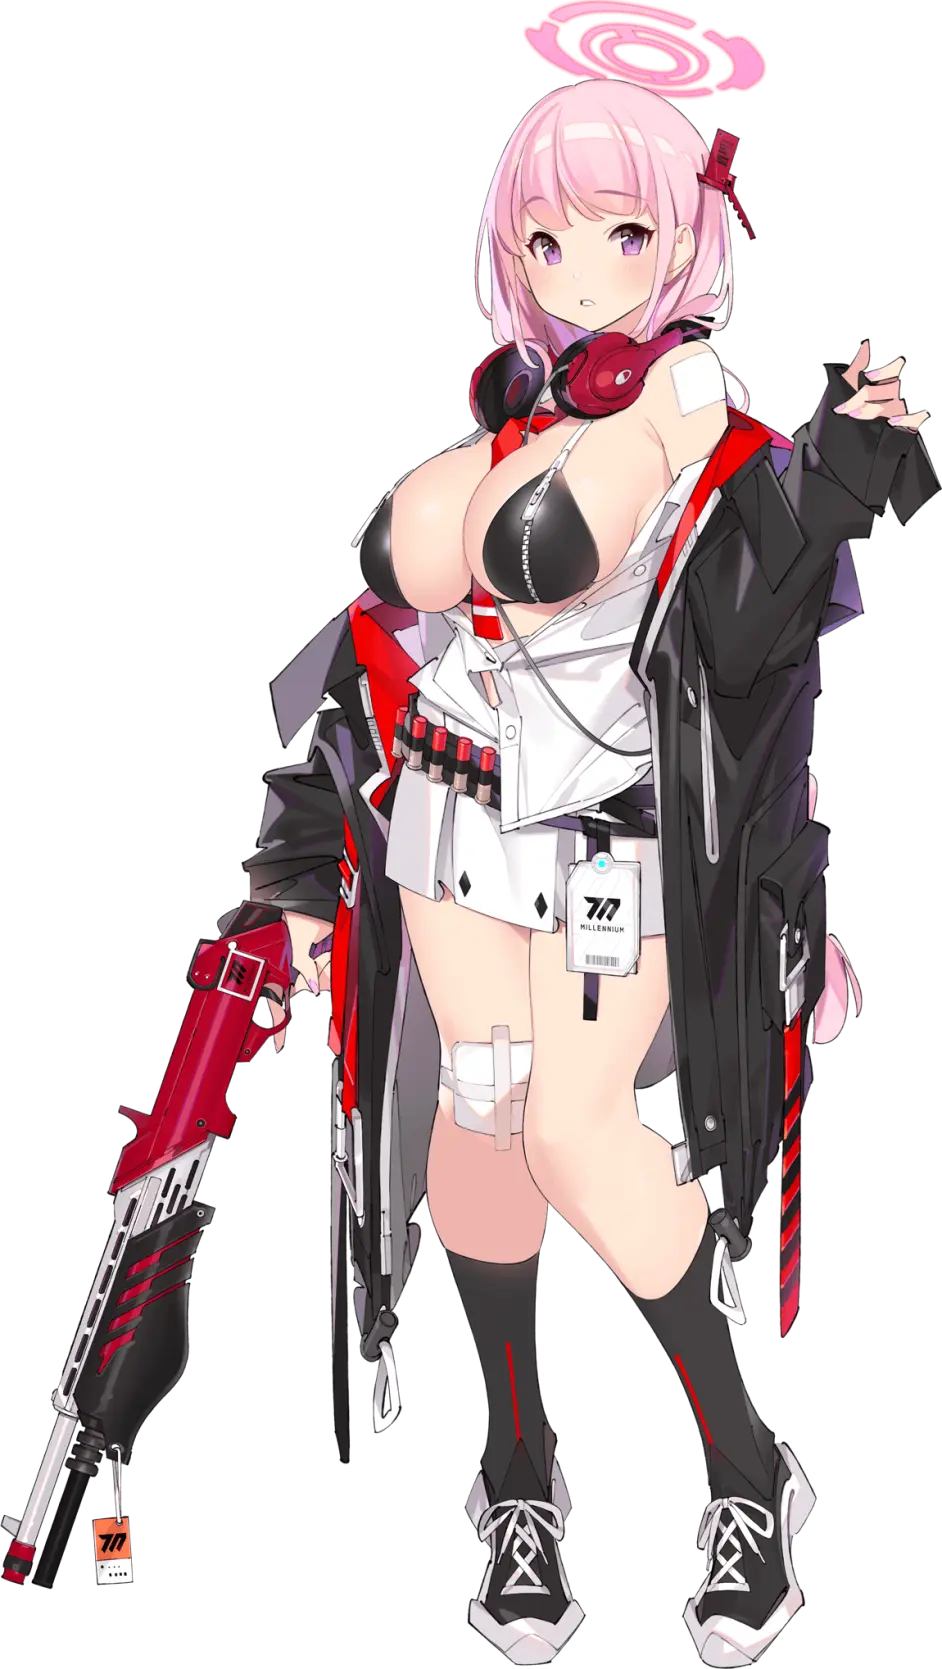

(896, 512, 3)


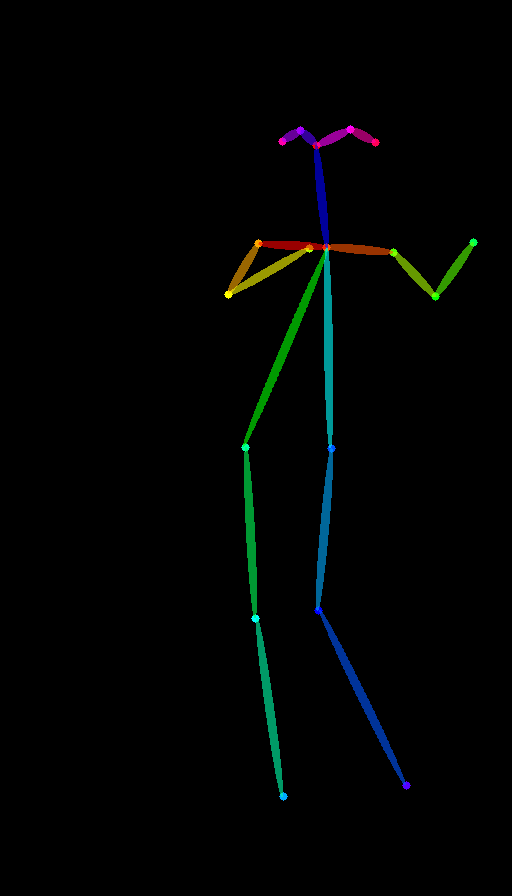

Selected timesteps for ddim sampler: [  1  26  51  76 101 126 151 176 201 226 251 276 301 326 351 376 401 426
 451 476 501 526 551 576 601 626 651 676 701 726 751 776 801 826 851 876
 901 926 951 976]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9757, 0.9505, 0.9229, 0.8930, 0.8607, 0.8264, 0.7901, 0.7521,
        0.7127, 0.6722, 0.6307, 0.5888, 0.5467, 0.5048, 0.4634, 0.4229, 0.3835,
        0.3456, 0.3093, 0.2750, 0.2428, 0.2128, 0.1851, 0.1598, 0.1369, 0.1163,
        0.0980, 0.0819, 0.0679, 0.0557, 0.0453, 0.0365, 0.0292, 0.0231, 0.0181,
        0.0140, 0.0107, 0.0082, 0.0061]); a_(t-1): [0.99914998 0.99829602 0.97565293 0.95052433 0.92294294 0.89298052
 0.86074883 0.82639927 0.79012191 0.75214338 0.71272361 0.67215145
 0.63073969 0.58881873 0.54672998 0.50481856 0.46342579 0.42288151
 0.38349706 0.34555823 0.3093195  0.27499905 0.24277493 0.21278252
 0.18511358 0.15981644 0.13689767 0.11632485 0.0980305  0.08191671
 0.06786042 0.05571903 0.04533602 0.03654652 0.0291824

DDIM Sampler: 100%|██████████| 40/40 [00:18<00:00,  2.18it/s]


In [23]:
from utils.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from annotator.openpose import OpenposeDetector
from PIL import Image
import numpy as np
%load_ext autoreload
%autoreload


apply_canny = CannyDetector()
apply_openpose = OpenposeDetector()

torch_device = 'cuda'

model.to(torch_device)
# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
# prompt = ["chisato, masterpiece, best quality, loli, animal ears, blue eyes, seduction, sea, wet,  cute face, long hair, white hair, 1girl, sexy,  8K, high resolution"]
prompt = ["masterpiece, best quality, seduction, sea, wet, cute face, 1girl, sexy,  8K, high resolution"]
prompt_negative = ["deformation, ugly, bad quality, distortion"]

random_seed = 626633957

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the postive text embedding: {positive_text_embeddings}')

# Negative Text Embedding
negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the negative text embedding: {negative_text_embeddings}')

# Prep latents


height = 896
width = 512


torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)


conditioning={'c_crossattn': [positive_text_embeddings]}
unconditional_conditioning={'c_crossattn': [negative_text_embeddings]}

def process_control(input_image, image_resolution, num_samples=1, low_threshold=100, high_threshold=200):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map, _ = apply_openpose(img)
        # detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)
        print(detected_map.shape)
        display(Image.fromarray(detected_map))
        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

    return control

control_image = Image.open('./../../data/dataset/blue-archive/character/ブルーアーカイブ0- 2.jpg')
display(control_image)
canny_1 = process_control(np.array(control_image), image_resolution=512)

add_prompt = 'takina'

conditioning['pose_1'] = [canny_1]
conditioning['pose_1_text'] = [model.get_learned_conditioning([prompt[0] + f", {add_prompt}"])]

unconditional_conditioning['pose_1'] = [canny_1]
unconditional_conditioning['pose_1_text'] = [model.get_learned_conditioning([prompt[0] + f", {add_prompt}"])]

# scheduler = DDIMScheduler(
#     num_train_timesteps=1000,
#     beta_start=0.00085,
#     beta_end=0.0120,
#     beta_schedule='scaled_linear'
# )


sample_ddim, intermediates = orig_sampler.sample(S=num_inference_steps, 
                             batch_size=1,
                             shape=(4, height // 8, width // 8),
                             conditioning=conditioning,
                             x_T=latents,
                             unconditional_conditioning=unconditional_conditioning,
                             unconditional_guidance_scale=cfg_scale)



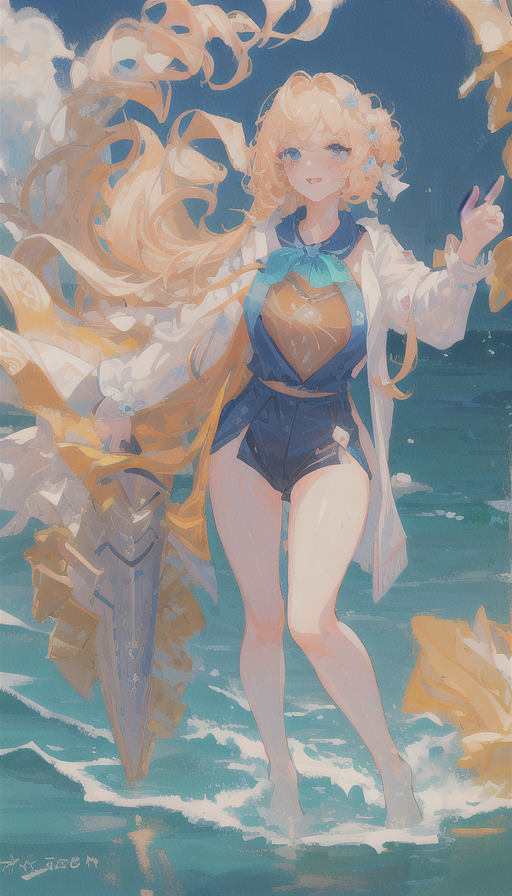

In [24]:
from PIL import Image
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# Training

In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from data.dataset import MyDataset

import importlib
import pytorch_lightning as pl
# importlib.reload(data.dataset.MyDataset)

class myLogger(ImageLogger):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if not self.disabled:
            self.log_img(pl_module, batch, batch_idx, split="train")

batch_size = 2
logger_freq = 300
learning_rate = 1e-5
sd_locked = True
only_mid_control = False


model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control


dataset = MyDataset()
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = myLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=16, callbacks=[logger], enable_checkpointing=False)


trainer.fit(model, dataloader)


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params
---------------------------------------------------------
0 | model             | DiffusionWrapper   | 859 M 
1 | first_stage_model | AutoencoderKL      | 83.7 M
2 | cond_stage_model  | FrozenCLIPEmbedder | 123 M 
3 | control_model     | MultiControlNet    | 361 M 
---------------------------------------------------------
1.2 B     Traina

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0202, v_num=1, train/loss_simple_step=0.0388, train/loss_vlb_step=0.000139, train/loss_step=0.0388, global_step=2.000, train/loss_simple_epoch=0.0164, train/loss_vlb_epoch=6.47e-5, train/loss_epoch=0.0164]        Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.04, v_num=1, train/loss_simple_step=0.059, train/loss_vlb_step=0.000195, train/loss_step=0.059, global_step=5.000, train/loss_simple_epoch=0.060, train/loss_vlb_epoch=0.000277, train/loss_epoch=0.060]             Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0685, v_num=1, train/loss_simple_step=0.265, train/loss_vlb_step=0.00257, train/loss_step=0.265, global_step=8.000, train/loss_simple_epoch=0.0975, train/loss_vlb_epoch=0.000773, train/loss_epoch=0.0975]          Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0628, v_num=1, train/loss_simple_step=0.0618, train/loss_vlb_step=0.000204, train/loss_step=0.0618, global_step=11.00, train/loss_simple_epoch=0.0424, train/loss_vlb_epoch=0.000142, train/loss_epoch=0.0424]        Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0702, v_num=1, train/loss_simple_step=0.119, train/loss_vlb_step=0.000409, train/loss_step=0.119, global_step=14.00, train/loss_simple_epoch=0.0959, train/loss_vlb_epoch=0.000442, train/loss_epoch=0.0959]          Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0822, v_num=1, train/loss_simple_step=0.166, train/loss_vlb_step=0.00103, train/loss_step=0.166, global_step=17.00, train/loss_simple_epoch=0.138, train/loss_vlb_epoch=0.000766, train/loss_epoch=0.138]           Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0757, v_num=1, train/loss_simple_step=0.00149, train/loss_vlb_step=8.72e-6, train/loss_step=0.00149, global_step=20.00, train/loss_simple_epoch=0.0198, train/loss_vlb_epoch=7.14e-5, train/loss_epoch=0.0198]        Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0788, v_num=1, train/loss_simple_step=0.104, train/loss_vlb_step=0.000359, train/loss_step=0.104, global_step=23.00, train/loss_simple_epoch=0.0583, train/loss_vlb_epoch=0.000289, train/loss_epoch=0.0583]          Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0786, v_num=1, train/loss_simple_step=0.0625, train/loss_vlb_step=0.000206, train/loss_step=0.0625, global_step=26.00, train/loss_simple_epoch=0.0247, train/loss_vlb_epoch=8.5e-5, train/loss_epoch=0.0247]           Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0772, v_num=1, train/loss_simple_step=0.0746, train/loss_vlb_step=0.000246, train/loss_step=0.0746, global_step=29.00, train/loss_simple_epoch=0.137, train/loss_vlb_epoch=0.00107, train/loss_epoch=0.137]        Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.087, v_num=1, train/loss_simple_step=0.118, train/loss_vlb_step=0.0005, train/loss_step=0.118, global_step=32.00, train/loss_simple_epoch=0.142, train/loss_vlb_epoch=0.00203, train/loss_epoch=0.142]              Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s, loss=0.0889, v_num=1, train/loss_simple_step=0.159, train/loss_vlb_step=0.000783, train/loss_step=0.159, global_step=35.00, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00123, train/loss_epoch=0.119]        Data shape for DDIM sampling is (2, 4, 32, 48), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:  44%|████▍     | 22/50 [00:03<00:04,  6.03it/s]


# Dataset

In [ ]:
from data.dataset import MyDataset

dataset_test = MyDataset()

print(dataset_test[0])


from PIL import Image
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


# Save Model Test

In [ ]:
state_dicts = model.multi_state_dict()

In [ ]:
model.save_weights('../../data/train-logs/')